# Bernstein–Vazirani Algorithm

This notebook runs the Bernstein–Vazirani algorithm on a local simulator and a QPU on Amazon Braket. The Bernstein-Vazirani algorithm can find a hidden binary string with certainty after only one call to the quantum circuit. The hidden string is releaved by querying the oracle that is a superposition of all possible binary strings.

The Bernstein–Vazirani problem is to find a hidden binary string given a black-box function that is promised to be the dot product of the input bitstring with the hidden string. It is an extension of the Deutsch-Jozsa algorithm where the function is restricted to being constant or balanced.

Typically, we would need to query the classical function $n$ times where $n$ is the length of the string. However, if the function is encoded into a quantum circuit, we need to only query the function once to reveal the hidden string. See Ref. [1] for full details.

# References 
[1] [Ethan Bernstein and Umesh Vazirani (1997) "Quantum Complexity Theory" SIAM Journal on Computing, Vol. 26, No. 5: 1411-1473, doi:10.1137/S0097539796300921.](https://epubs.siam.org/doi/10.1137/S0097539796300921)


# Bernstein-Vazirani Circuit Recap

<img src="bv_circuit.png" alt="bv" style="width: 400px;"/>

In [50]:
from braket.circuits import Circuit
        
def bv(string):
    
    num_qubits = len(string) + 1
    
    # Turn the ancilla to |1>
    bv_circ = Circuit().x(num_qubits - 1)    
    
    # Initial Hadamard layer
    for i in range(0, num_qubits):
        bv_circ.h(i)
    
    # Oracle
    for i in range(num_qubits - 1):
        if string[i] == '1':
            bv_circ.cnot(i, num_qubits - 1)
        elif string[i] != '0':
            raise ValueError("Not a valid bit string")
    
    # Final Hadamard layer
    for i in range(0, num_qubits):
        bv_circ.h(i)
    
    bv_circ.amplitude(state=string_combinations)
    
    return bv_circ

In [51]:
print(bv("1010"))

T  : |0|1|2|3|4|
                
q0 : -H---C-H---
          |     
q1 : -H-H-|-----
          |     
q2 : -H---|-C-H-
          | |   
q3 : -H-H-|-|---
          | |   
q4 : -X-H-X-X-H-

T  : |0|1|2|3|4|

Additional result types: Amplitude(00001,00011,00101,00111,01001,01011,01101,01111,10001,10011,10101,10111,11001,11011,11101,11111)


# Understand how Berstein-Vazirani encode the information in the phase

In [58]:
import itertools
string_combinations = [''.join(i) + '1' for i in itertools.product('01', repeat=4)]

In [59]:
def bv_after_first_h_layer(string):
    
    num_qubits = len(string) + 1
    bv_circ = Circuit().x(num_qubits - 1)    
    for i in range(0, num_qubits):
        bv_circ.h(i)
        
    bv_circ.amplitude(state=string_combinations)
    
    return bv_circ

In [60]:
def bv_after_oracle(string):
    
    num_qubits = len(string) + 1
    bv_circ = Circuit().x(num_qubits - 1)    
    for i in range(0, num_qubits):
        bv_circ.h(i)
        
    for i in range(num_qubits - 1):
        if string[i] == '1':
            bv_circ.cnot(i, num_qubits - 1)
        elif string[i] != '0':
            raise ValueError("Not a valid bit string")
            
    bv_circ.amplitude(state=string_combinations)
    
    return bv_circ

{'00001': (-0.1767766952966368+0j), '00011': (-0.1767766952966368+0j), '00101': (-0.1767766952966368+0j), '00111': (-0.1767766952966368+0j), '01001': (-0.1767766952966368+0j), '01011': (-0.1767766952966368+0j), '01101': (-0.1767766952966368+0j), '01111': (-0.1767766952966368+0j), '10001': (0.1767766952966368+0j), '10011': (0.1767766952966368+0j), '10101': (0.1767766952966368+0j), '10111': (0.1767766952966368+0j), '11001': (0.1767766952966368+0j), '11011': (0.1767766952966368+0j), '11101': (0.1767766952966368+0j), '11111': (0.1767766952966368+0j)}


/home/ec2-user/anaconda3/envs/Braket/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


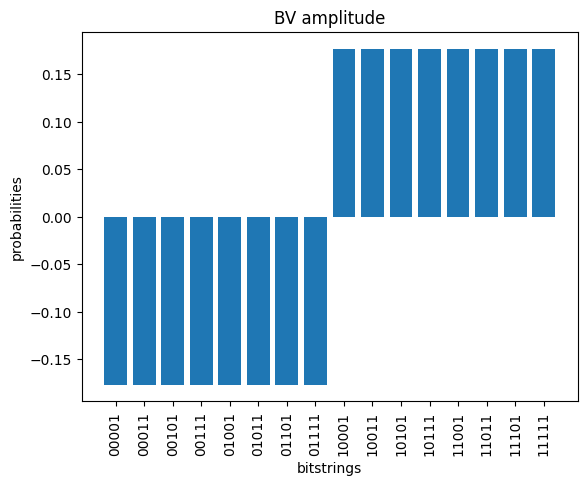

In [67]:
from braket.devices import LocalSimulator
from notebook_plotting import plot_bitstrings

local_simulator = LocalSimulator()
task = local_simulator.run(bv_after_oracle("1000"), shots=0)
result = task.result()
print(result.values[0])
plot_bitstrings(result.values[0], title="BV amplitude")

# Using the Amazon Braket Berstein-Vazirani library to run on a local simulator

In [28]:
from notebook_plotting import plot_bitstrings

%matplotlib inline

from braket.devices import LocalSimulator
from braket.tracking import Tracker

from braket.experimental.algorithms.bernstein_vazirani import (
    bernstein_vazirani_circuit,
    get_bernstein_vazirani_results,
    run_bernstein_vazirani
)

tracker = Tracker().start() # to track Braket costs

In [29]:
bv_circuit = bernstein_vazirani_circuit("1010")
print(bv_circuit)

T  : |0|1| 2 |3|4|Result Types|
                               
q0 : -H---C---H---Probability--
          |       |            
q1 : -H-I-|-H-----Probability--
          |       |            
q2 : -H---|---C-H-Probability--
          |   |   |            
q3 : -H-I-|-H-|---Probability--
          |   |                
q4 : -H-Z-X---X----------------

T  : |0|1| 2 |3|4|Result Types|


In [30]:
local_simulator = LocalSimulator()
task = run_bernstein_vazirani(bv_circuit, local_simulator, shots=1_000)
print(task)

LocalQuantumTask('id':ffb115f5-5389-4041-93b5-7baef6f8c871)


In [33]:
bv_results = get_bernstein_vazirani_results(task)

<class 'dict'>


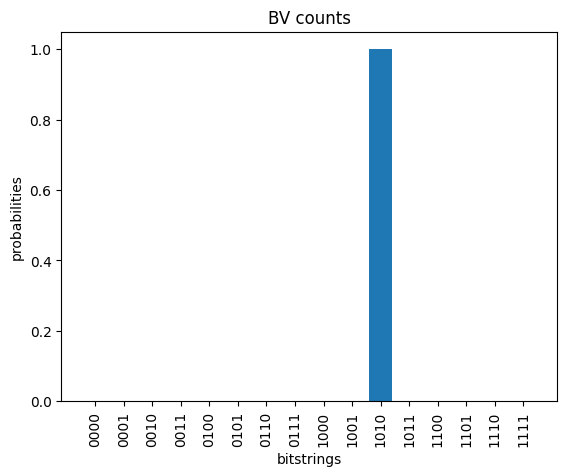

In [15]:
plot_bitstrings(bv_results, title="BV counts")

# Run on a noisy simulator

Let's try a noisy simulator

In [16]:
from braket.circuits.noises import BitFlip, Depolarizing

noisy_bv_circuit = (
    bernstein_vazirani_circuit("001")
    .apply_gate_noise(Depolarizing(0.01))
    .apply_readout_noise(BitFlip(0.1))
)
print(noisy_bv_circuit)

T  : |     0      |     1      |     2      |            3             |Result Types|
                                                                                     
q0 : -H-DEPO(0.01)-I-DEPO(0.01)-H-DEPO(0.01)-BF(0.1)--------------------Probability--
                                                                        |            
q1 : -H-DEPO(0.01)-I-DEPO(0.01)-H-DEPO(0.01)-BF(0.1)--------------------Probability--
                                                                        |            
q2 : -H-DEPO(0.01)--------------C-DEPO(0.01)-H-------DEPO(0.01)-BF(0.1)-Probability--
                                |                                                    
q3 : -H-DEPO(0.01)-Z-DEPO(0.01)-X-DEPO(0.01)-BF(0.1)---------------------------------

T  : |     0      |     1      |     2      |            3             |Result Types|


In [17]:
local_simulator = LocalSimulator("braket_dm")

task = run_bernstein_vazirani(noisy_bv_circuit, local_simulator, shots=1_000)

noisy_bv_results = get_bernstein_vazirani_results(task)

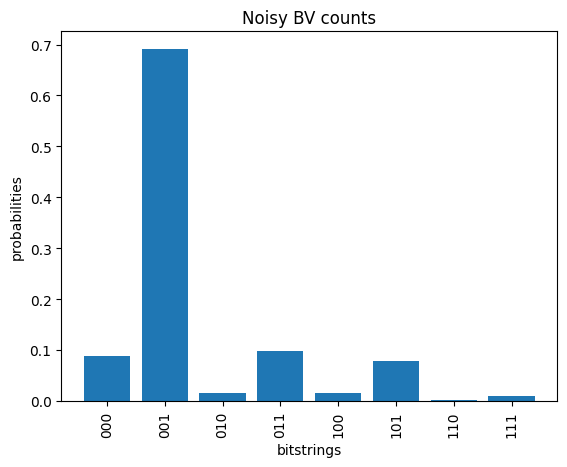

In [18]:
plot_bitstrings(noisy_bv_results, title="Noisy BV counts")

In [19]:
print("Task Summary")
print(f"{tracker.quantum_tasks_statistics()} \n")
print(f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost():.2f} USD")

Task Summary
{} 

Estimated cost to run this example: 0.00 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).